<a href="https://colab.research.google.com/github/RodrigoLima82/bootcamp_igti_machine_learning/blob/master/Modulo_05/desafio_final_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio Final - IGTI - Cars
- Autor: Rodrigo de Lima Oliveira
- LinkedIn: https://www.linkedin.com/in/rodrigolima82/

![title](https://github.com/RodrigoLima82/bootcamp_igti_machine_learning/blob/master/Modulo_05/cars_image.png?raw=1)

## Carregando as bibliotecas

In [158]:
# Instalando bibliotecas no Google Colab
!pip install -q scikit-plot
!pip install -q watermark

In [159]:
# Imports de avisos
import sys
import warnings
import matplotlib.cbook
warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import math
import itertools

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000

In [160]:
# Carregando bibliotecas do pacote sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, classification_report, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [161]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Desafio Final - Rodrigo" --iversions

matplotlib      3.2.2
scipy           1.4.1
statsmodels.api 0.10.2
pandas          1.0.5
plotly          4.4.1
seaborn         0.10.1
numpy           1.18.5
Desafio Final - Rodrigo


# Criando funções que serão utilizadas neste notebook

In [162]:
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Ótimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)
        
# Funcao para criar um grafico de distribuicao pra cada feature do dataset
def plot_distribution(dataset, cols=5, width=20, height=25, hspace=0.4, wspace=0.5):
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, 
                              data=dataset,
                              order=dataset[column].value_counts().index[:10])
            substrings = [s.get_text()[:20] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)        
            
# Funcao para calcular o coeficiente de correlacao entre duas variaveis
def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2     

## Carregar de arquivo CSV

In [163]:
# Importando o arquivo 'cars.csv'
from google.colab import files
uploaded = files.upload()

Saving cars.csv to cars (4).csv


In [164]:
train = pd.read_csv('cars.csv')

# Visualizando o shape do dataset (261 linhas x 8 colunas)
print(train.shape)

# Verificando os tipos de dados
train.info()

# Visualizando as primeiras linhas do dataset
train.head()

(261, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mpg          261 non-null    float64
 1   cylinders    261 non-null    int64  
 2   cubicinches  261 non-null    object 
 3   hp           261 non-null    int64  
 4   weightlbs    261 non-null    object 
 5   time-to-60   261 non-null    int64  
 6   year         261 non-null    int64  
 7   brand        261 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 16.4+ KB


,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


# Analise Exploratória dos Dados

In [165]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,261.0,23.144828,7.823570,10.0,16.9,22.0,28.8,46.6
cylinders,261.0,5.590038,1.733310,3.0,4.0,6.0,8.0,8.0
hp,261.0,106.360153,40.499959,46.0,75.0,95.0,138.0,230.0
time-to-60,261.0,15.547893,2.910625,8.0,14.0,16.0,17.0,25.0
year,261.0,1976.819923,3.637696,1971.0,1974.0,1977.0,1980.0,1983.0


In [166]:
# Verificando as colunas com dados missing do dataset
check_missing(train, display = 8)

Ótimo! Não há mais valores faltantes neste dataset.


In [167]:
# Verificando valores únicos
for col in list(train.columns):
    
    # Obtém uma lista de valores únicos
    list_of_unique_values = train[col].unique()
    
    # Se o número de valores exclusivos for menor que 15, imprima os valores. 
    # Caso contrário, imprima o número de valores exclusivos
    if len(list_of_unique_values) < 15:
        #print("\n")
        print(col + ': ' + str(len(list_of_unique_values)) + ' valores únicos')
        print(list_of_unique_values)
    else:
        #print("\n")
        print(col + ': ' + str(len(list_of_unique_values)) + ' valores únicos')

mpg: 103 valores únicos
cylinders: 5 valores únicos
[8 4 5 6 3]
cubicinches: 75 valores únicos
hp: 85 valores únicos
weightlbs: 240 valores únicos
time-to-60: 17 valores únicos
year: 13 valores únicos
[1972 1980 1971 1978 1974 1982 1983 1981 1975 1973 1977 1976 1979]
brand: 3 valores únicos
[' US.' ' Europe.' ' Japan.']


## Analisando as feature do dataset

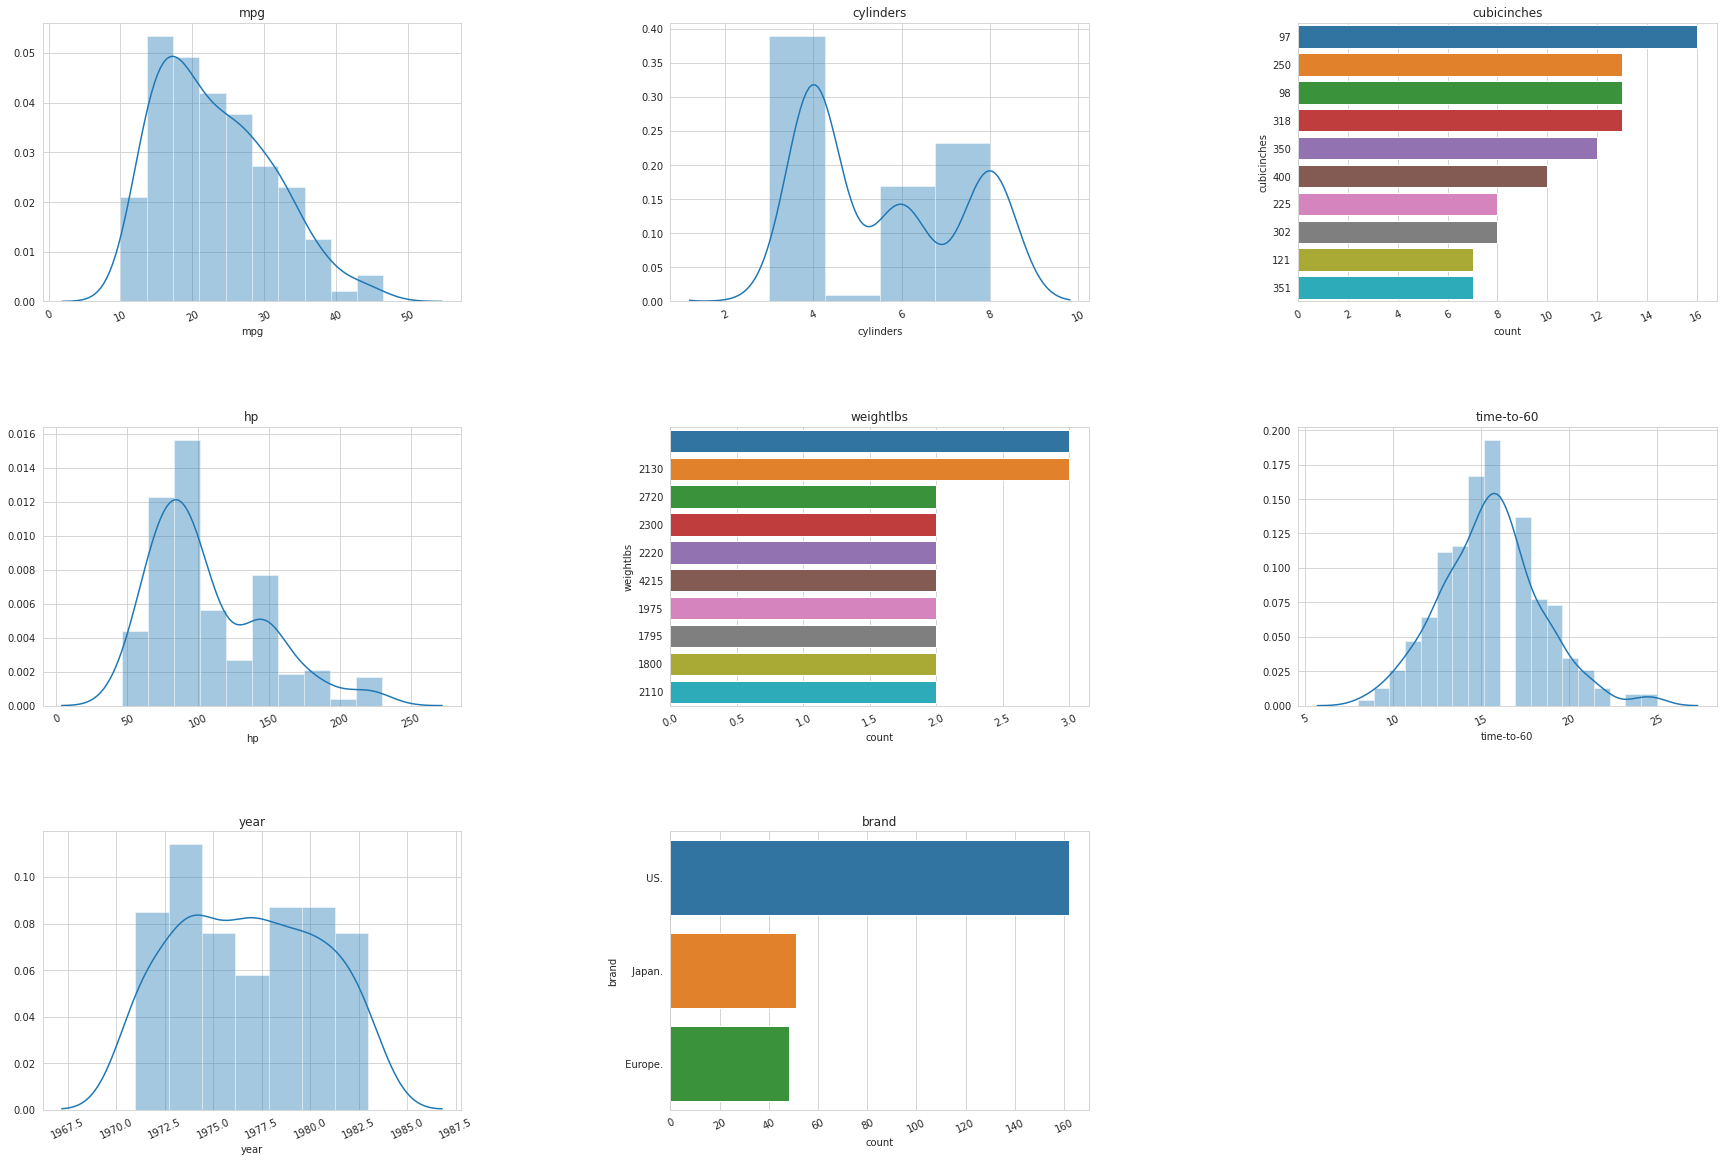

In [168]:
# Gráfico de distribuição para cada feature do dataset
columns = ['mpg', 'cylinders', 'cubicinches', 'hp', 'weightlbs', 'time-to-60', 'year', 'brand']
plot_distribution(train[columns], cols=3, width=30, height=20, hspace=0.45, wspace=0.5)

# Visão geral

> - O conjunto de dados **'cars'** do exemplo contém 261 registros e 8 colunas;
- Analisando os valores faltantes, não foi encontrado nenhum registro, portanto, não será necessário se preocupar com esse tipo de problema comum;
- As features `cubicinches` e `weightlbs` foram classificadas pelo pandas como categóricas, mas tudo indica serem numéricas (vamos avaliar a transformação daqui a pouco);

## Transformação das features `cubicinches` e `weightlbs`

In [169]:
cols_to_numeric = ['cubicinches','weightlbs']
train[cols_to_numeric] = train[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

In [170]:
# Verificando se após a transformação encontramos valores missing no dataset
check_missing(train, display = 8)

,Missing n,% Missing
weightlbs,3,1.149425
cubicinches,2,0.766284
mpg,0,0.000000
cylinders,0,0.000000
hp,0,0.000000
time-to-60,0,0.000000
year,0,0.000000
brand,0,0.000000


In [171]:
# Verificando os registros que contem valores nulos
train[train.isnull().any(axis=1)]

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
14,19.1,6,225.0,90,NaN,19,1981,US.
33,21.0,6,199.0,90,NaN,15,1971,US.
40,16.0,6,NaN,105,3897.0,19,1976,US.
172,29.0,4,68.0,49,NaN,20,1974,Europe.
180,19.8,6,NaN,85,2990.0,18,1980,US.


## Observações

> - Após a transformação das features `cubicinches` e `weightlbs` do tipo string para numerica, houve mudanças nos dados, sendo que agora temos 5 registros com valores nulos nessas duas colunas
- Os índices desses registros são: 14, 33, 40, 172 e 180

## Tratamento de valores missing

In [172]:
# Para corrigir os valores nulos, vamos atribuir a media dos valores das respectivas colunas
train['cubicinches'].fillna(train.cubicinches.mean(), inplace=True)
train['weightlbs'].fillna(train.weightlbs.mean(), inplace=True)

In [173]:
train.describe()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,23.144828,5.590038,200.918919,106.360153,3009.833333,15.547893,1976.819923
std,7.823570,1.733310,108.837269,40.499959,849.097575,2.910625,3.637696
min,10.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,1971.000000
25%,16.900000,4.000000,101.000000,75.000000,2254.000000,14.000000,1974.000000
50%,22.000000,6.000000,156.000000,95.000000,2904.000000,16.000000,1977.000000
75%,28.800000,8.000000,302.000000,138.000000,3664.000000,17.000000,1980.000000
max,46.600000,8.000000,455.000000,230.000000,4997.000000,25.000000,1983.000000


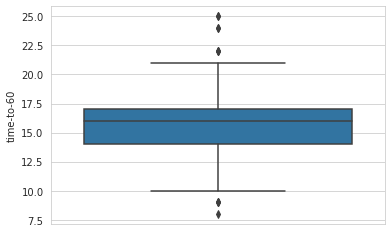

In [174]:
# Verificando os dados da feature 'time-to-60' através de um boxplot
sns.set_style("whitegrid")  
sns.boxplot(y='time-to-60', data=train);

## Observações

> - Vamos detalhar essas interpretações:
    - O centro da distribuição é indicado pela linha da mediana, no centro do quadrado (no exemplo é 16).
    - A dispersão é representada pela amplitude do gráfico, que pode ser calculada como máximo valor – mínimo valor. Quanto maior for a amplitude, maior a variação nos dados.
    - O retângulo contém 50% dos valores do conjunto de dados. A posição da linha mediana no retângulo informa sobre a assimetria da distribuição. Uma distribuição simétrica teria a mediana no centro do retângulo. Se a mediana é próxima de Q1, então, os dados são positivamente assimétricos.Se a mediana é próxima de Q3 os dados são negativamente assimétricos. 
    - Os outliers em um box plot aparecem como pontos ou asteriscos fora das “linhas” desenhadas. Perceba que no exemplo, temos um outlier representado pelo ponto no começo e no final do gráfico.

## Visualizando a correlação das features

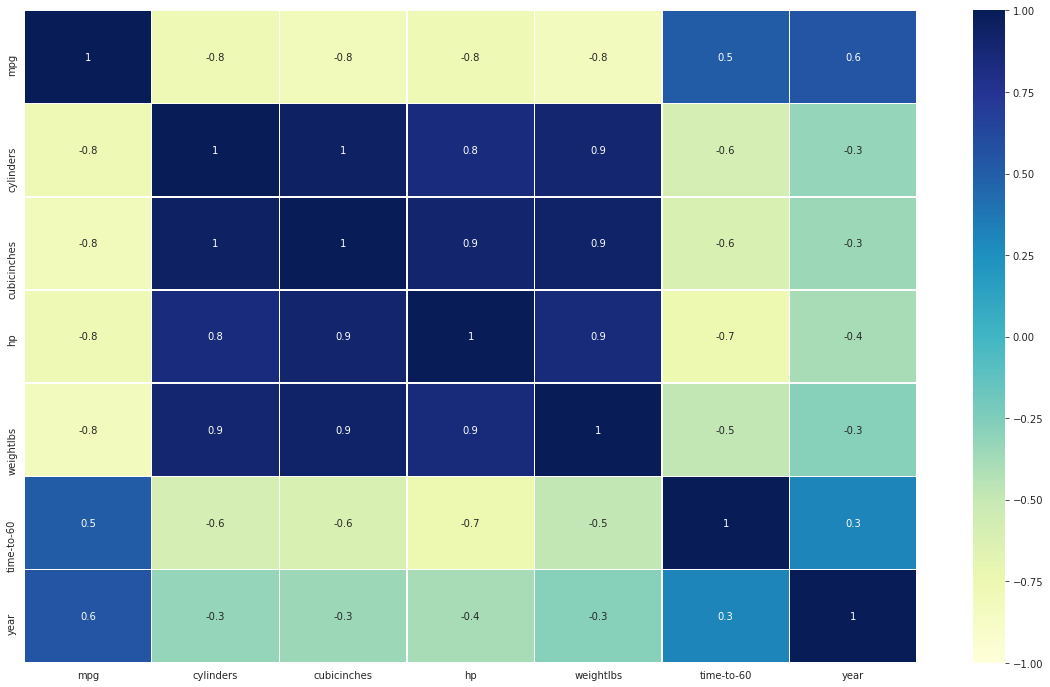

In [175]:
plt.figure(figsize=(20, 12))

# Selecionando apenas algumas colunas para verificar a correlação
corr = train.corr(method = 'pearson')

# Configurar o heatmap
sns.heatmap(corr, linewidths=.5, vmin=-1, vmax=1, annot=True, cmap="YlGnBu", fmt='.1g')

# Imprimir o grafico
plt.show();

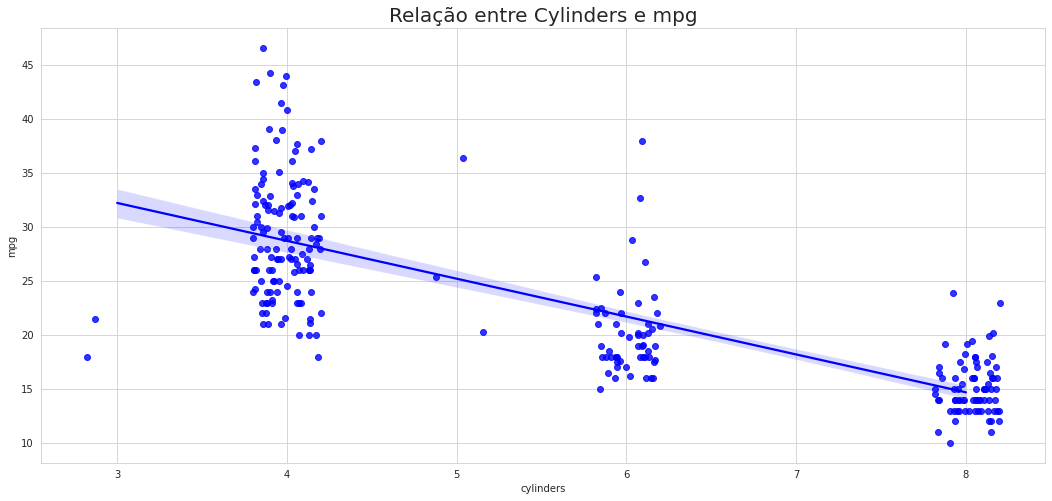

In [176]:
# Visualiza um gráfico entre as variaveis cylinders e mpg e verificar se existe alguma correlação linear
plt.figure(figsize=(18, 8))
sns.regplot(x='cylinders', y='mpg', data=train, color='b', x_jitter=0.2)
plt.xlabel('cylinders')
plt.ylabel('mpg')
plt.title('Relação entre Cylinders e mpg', fontsize=20)
plt.show();

### Calculando o coeficiente de correlação de duas formas

In [177]:
# Calculando o coeficiente de correlação entre 'cylinders' e 'mpg' através do r2
rsquared(train['cylinders'], train['mpg'])

0.6032782423312325

In [178]:
# Calculando o coeficiente de correlação pelo OLS e exibindo um sumario
model = sm.OLS(train['mpg'], train['cylinders'])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.692
Model:                            OLS   Adj. R-squared (uncentered):              0.691
Method:                 Least Squares   F-statistic:                              583.7
Date:                Sun, 12 Jul 2020   Prob (F-statistic):                    2.07e-68
Time:                        00:03:49   Log-Likelihood:                         -1050.8
No. Observations:                 261   AIC:                                      2104.
Df Residuals:                     260   BIC:                                      2107.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cylinders      3.4721      0.144     24.160      0.000       3.189       3.755
==============================================================================
Omnibus:                      164.032   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.509
Skew:                           0.004   Prob(JB):                     0.000260
Kurtosis:                       1.768   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Observações

> - De acordo com o gráfico de correlação de Person, temos uma correlação negativa (-0,8) entre as features `cylinders` e `mpg`;
- Isso significa que quanto maior aumenta a quantidade de cilindros, menos é o mpg do carro;
- Isso fica evidente no gráfico regplot apresentado;
- Quando calculamos o coeficiente de correlação, chegamos no valor aproximado de 0.69, como é possível observar nas duas formas propostas acima;

## Analisando a feature `hp` 

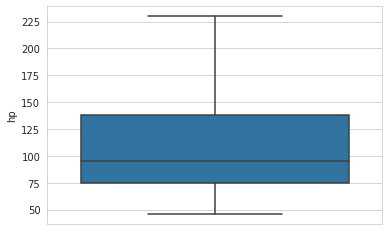

In [179]:
# Verificando os dados da feature 'hp' através de um boxplot
sns.set_style("whitegrid")  
sns.boxplot(y='hp', data=train);

## Observações

> - De acordo com o boxplot da feature `hp` não há evidências de valores outliers;
- De acordo com a posição da linha mediana no retângulo, que nos indica que está mais próxima de Q1, podemos inferir que os dados são positivamente assimétricos;
- Através desse gráfico é possível observar que a mediana está entre 80 e 100 (no describe acima vimos que é 95).

# Padronizando as features do dataset

In [180]:
# Cria o padronizador
scaler = StandardScaler()

# Definindo somente colunas numericas a serem padronizadas
num_cols = train.columns[train.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

# Criar uma copia do dataset original
new_train = train[num_cols]

# Padronizando os dados
new_train[num_cols] = scaler.fit_transform(new_train[num_cols])

# Exibindo os primeiros registros
new_train.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year
0,-1.171127,1.393053,1.372393,1.450681,1.414997,-1.221287,-1.327539
1,1.121226,-0.919105,-1.030290,-0.874768,-1.280086,-0.532829,0.875880
2,-0.786934,1.393053,0.930520,0.832210,0.518209,-1.565516,-1.602966
3,-1.043063,1.393053,1.832677,1.079598,0.886364,-1.909745,-1.602966
4,0.941936,-0.919105,-0.947439,-1.072679,-1.131408,0.499857,0.325025


In [181]:
# Verificando o maior valor para a feature 'hp'
new_train['hp'].max()

3.05870398977614

## Observações

> - A idéia por trás de StandardScaler é que ele transformará seus dados de tal forma que sua distribuição terá um valor médio 0 e um desvio padrão de 1. Dada a distribuição dos dados, cada valor no conjunto de dados terá o valor médio da amostra. subtraído e, em seguida, dividido pelo desvio padrão de todo o conjunto de dados;
- Analisando a feature `hp`, após a padronização o maior valor é de 3.05

## Aplicando o PCA e analisando a variância

In [182]:
pca = PCA(n_components=7)
principalComponents = pca.fit_transform(new_train)

# Salvando em um dataframe
PCA_components = pd.DataFrame(principalComponents)
PCA_components.head()

,0,1,2,3,4,5,6
0,3.485219,0.526326,-0.139738,0.258792,0.086902,-0.179206,0.079078
1,-2.176912,-0.285424,-1.304613,-0.100465,-0.289698,-0.041147,-0.013127
2,2.684973,1.046946,-0.732156,0.498227,-0.535168,-0.075745,0.159956
3,3.534648,0.847619,-0.801334,0.506630,-0.435696,-0.144237,-0.483162
4,-2.299222,0.194808,-0.221704,0.079650,-0.175655,0.015566,-0.069958


In [183]:
# Exibindo o valor da variância explicada por cada componente
print(pca.explained_variance_ratio_)

[0.72371349 0.12675138 0.09126131 0.02773591 0.01766794 0.00798425
 0.00488572]


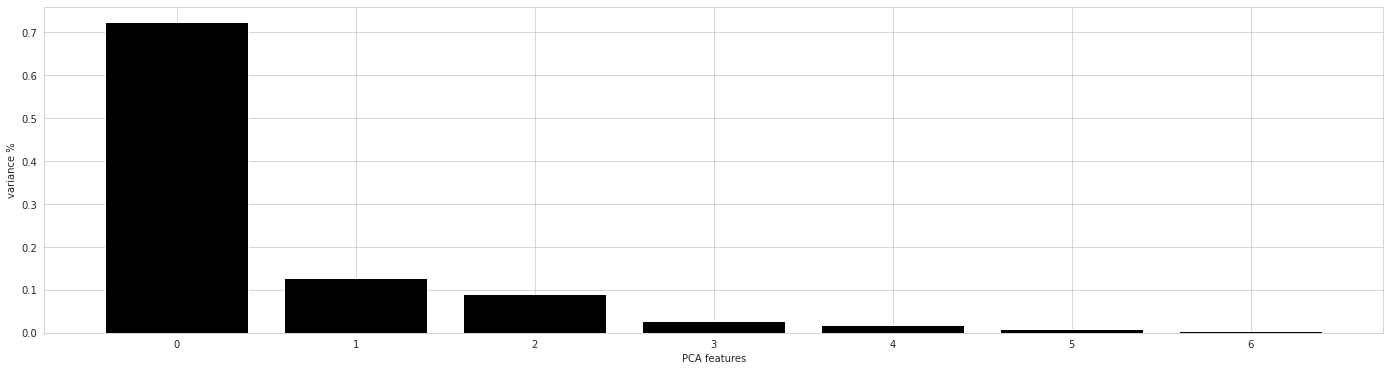

In [184]:
# Plot da variação explicada pelos componentes
features = range(pca.n_components_)

fig, aux = plt.subplots(1,1, figsize=(24, 6))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features);

## Observações

> - A análise dos componentes principais - ACP ou PCA é um método que tem por finalidade básica a análise dos dados visando sua redução, eliminação de sobreposições e a **escolha das formas mais representativas dos dados a partir de combinações lineares das variaveis originais**;
- A PCA consiste em promover uma transformação linear nos dados de modo que os dados resultantes desta transformação tenham suas componentes mais relevantes nas primeiras dimensões, em eixos denominados principais;
- A matriz  de  covariância contém informação sobre as variâncias em todos os eixos onde os dados estão distribuídos
- No caso do nosso exemplo, o valor da variância explicada pela primeira componente principal é de **72,3%**.

# Construindo um modelo K-means

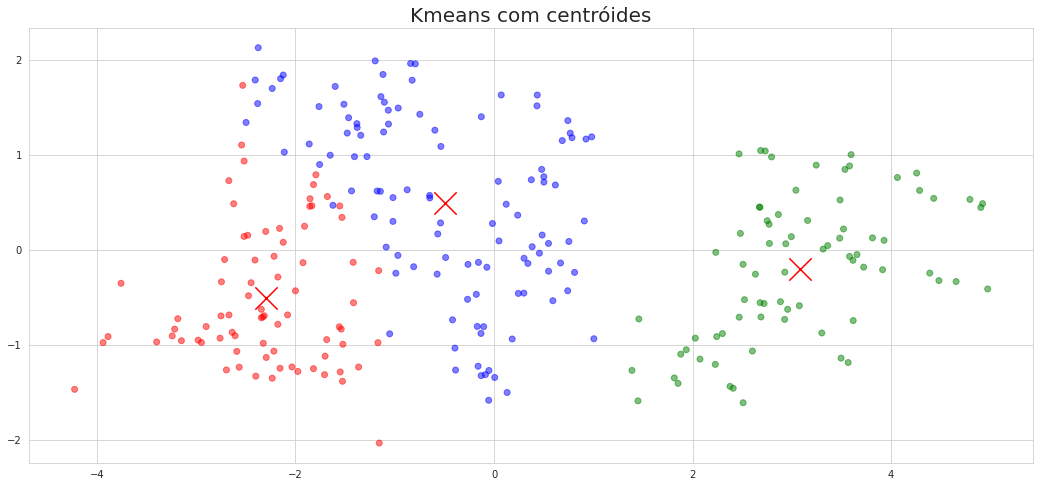

In [185]:
# Inicializando o kmeans
kmeans = KMeans(n_clusters=3, random_state=42)

# Treinar o modelo utilizando apenas os tres primeiros componentes principais
kmeans.fit(PCA_components.iloc[:,:3])

# Realizando as previsoes dos cluster
X_clustered = kmeans.predict(PCA_components.iloc[:,:3])

# Definindo um mapa de cor para cada cluster
color_map = {0:'r', 1: 'g', 2: 'b'}
label_color = [color_map[l] for l in X_clustered]

# Definindo os centroides
centers = np.array(kmeans.cluster_centers_)

# Exibindo um grafico scatter
fig, aux = plt.subplots(1,1, figsize=(18, 8))
plt.title('Kmeans com centróides', fontsize=20)
plt.scatter(principalComponents[:,0],principalComponents[:,1], c= label_color, alpha=0.5) 
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', s=500)
plt.show();

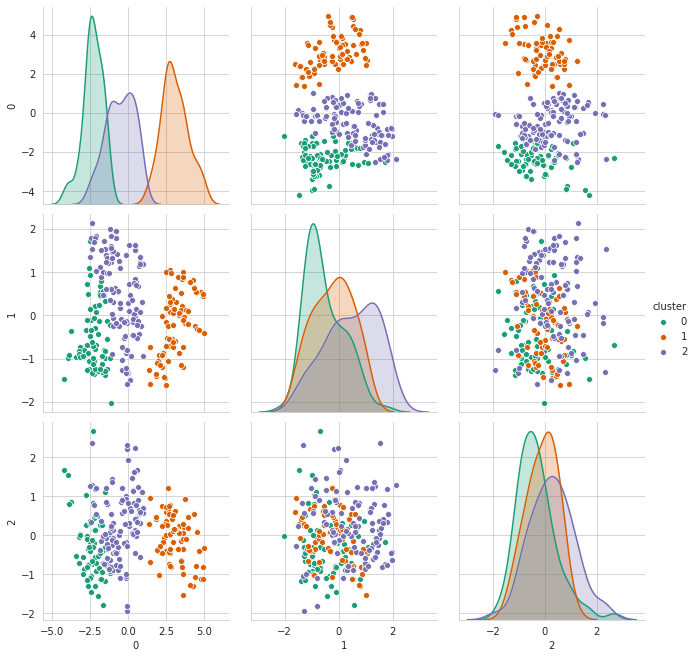

In [186]:
# Criando um dataframe do nosso PCA
df = pd.DataFrame(PCA_components)

# Selecionando somente os 3 primeiros componentes
df = df[[0,1,2]]
df['cluster'] = X_clustered

# Visualizando nossos clusters com os dados do PCA
sns.pairplot(df, hue='cluster', palette= 'Dark2', diag_kind='kde', size=3);


2    109
0     77
1     75
Name: cluster, dtype: int64


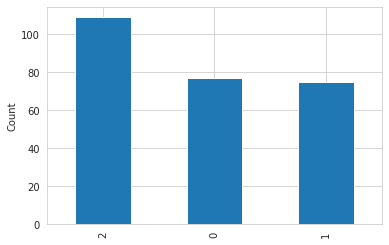

In [187]:
# Verificando a quantidade em cada um dos clusters
print(df['cluster'].value_counts())

# Exibindo em um gráfico
df['cluster'].value_counts().plot(kind = 'bar')
plt.ylabel('Count');

## Observações

> - Utilizando os 3 primeiros componentes principais para construir o K-means com um número de 3 clusters, podemos verificar que:
    - Os centroides, utilizando apenas as 3 componentes principais, possuem 3 dimensões;
    - Existem 3 centroides após a aplicação da clusterização;
    - Cada um dos clusters possui características próprias.

# Criação e Validação dos Modelos de Machine Learning

### Preparando os dados para treinamento do baseline

- Vamos criar uma nova feature no nosso dataset
- Para isso, preciso buscar o valor original da feature 'mpg' e concatenar com o dataset do PCA
- Como estratégia, farei o merge dos dois datasets pelo index

In [188]:
# Realizando o merge com o dataset final
df_final = train .merge(df, left_index=True, right_index=True)

# Cria a nova feature mpg
# Regra: veículos que percorrem mais de 25 milhas com um galão (“mpg” > 25) devem ser considerados eficientes
df_final['new_mpg'] = np.where(df_final['mpg'] > 25, 1, 0)

# Exibir o dataset final
df_final.head()


,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand,0,1,2,cluster,new_mpg
0,14.0,8,350.0,165,4209.0,12,1972,US.,3.485219,0.526326,-0.139738,1,0
1,31.9,4,89.0,71,1925.0,14,1980,Europe.,-2.176912,-0.285424,-1.304613,0,1
2,17.0,8,302.0,140,3449.0,11,1971,US.,2.684973,1.046946,-0.732156,1,0
3,15.0,8,400.0,150,3761.0,10,1971,US.,3.534648,0.847619,-0.801334,1,0
4,30.5,4,98.0,63,2051.0,17,1978,US.,-2.299222,0.194808,-0.221704,0,1


In [189]:
# Vamos armazenar 'new_mpg' no rótulo (y) e o restante das colunas em X
y = df_final['new_mpg']
X = df_final[['cylinders','cubicinches','hp','weightlbs','time-to-60']]

# Cria o padronizador
scaler = StandardScaler()

# Padronizando os dados
X = scaler.fit_transform(X)

# Split dos dados
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, random_state=42)

# Verificando o shape apos o split entre feature e target
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(182, 5) (182,) (79, 5) (79,)


### Realizando o treinamento de todos os modelos

In [190]:
# Preparando a lista de modelos
modelos = []
modelos.append(('LogisticRegression', LogisticRegression(random_state=42)))
modelos.append(('DecisionTree', DecisionTreeClassifier(random_state=42)))

# Avaliando cada modelo em um loop
for nome, modelo in modelos:
    
    # realizando o fit do modelo
    modelo.fit(X_train, y_train)
    
    # avaliando o score com dados de validação
    score = modelo.score(X_valid, y_valid)   
    
    # exibindo o resultado
    print('\n')
    msg = "%s: %f" % (nome, score)
    print(msg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



LogisticRegression: 0.860759


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')



DecisionTree: 0.873418


## Observações

> - Conseguimos a seguinte acurácia para o baseline:
    - **LogisticRegression = 86%**
    - **DecisionTree = 87%**
- A árvore de decisão e a regressão logística podem ser utilizadas para previsão em regressões;
- A acurácia de ambos os modelos foi superior a 80%;
- Como os dois modelos obtiveram um resultado superior a 80% de acurácia, a escolha sobre qual utilizar deve e pode ser feita a partir de outros critérios, como a complexidade do modelo.

### Realizando o treinamento com **DECISION TREE**

In [191]:
# Treinando o modelo de Arvore de Decisão
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# Realizar as previsões
previsoes = model_dt.predict(X_valid)

# Fazendo as previsões e construindo o relatório
report = classification_report(y_valid, previsoes)

# Imprimindo o relatório
print(report)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

              precision    recall  f1-score   support

           0       0.94      0.80      0.87        41
           1       0.82      0.95      0.88        38

    accuracy                           0.87        79
   macro avg       0.88      0.88      0.87        79
weighted avg       0.88      0.87      0.87        79



### Confusion Matrix

In [192]:
# Funcao para exibir o gráfico de matriz de confusao
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

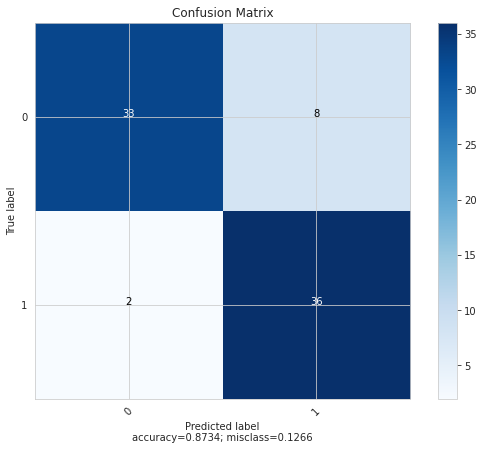

In [193]:
# Permite verificar a acurácia em um formato de tabela
matrix = confusion_matrix(y_valid, previsoes)

# Chamando a função para visualizar a confusion matrix
plot_confusion_matrix(matrix, 
                      target_names = ['0', '1'],
                      normalize    = False,
                      title        = "Confusion Matrix")

### Realizando o treinamento com **LOGISTIC REGRESSION**

In [194]:
# Treinando o modelo de Arvore de Decisão
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Realizar as previsões
previsoes = model_lr.predict(X_valid)

# Fazendo as previsões e construindo o relatório
report = classification_report(y_valid, previsoes)

# Imprimindo o relatório
print(report)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        41
           1       0.86      0.84      0.85        38

    accuracy                           0.86        79
   macro avg       0.86      0.86      0.86        79
weighted avg       0.86      0.86      0.86        79



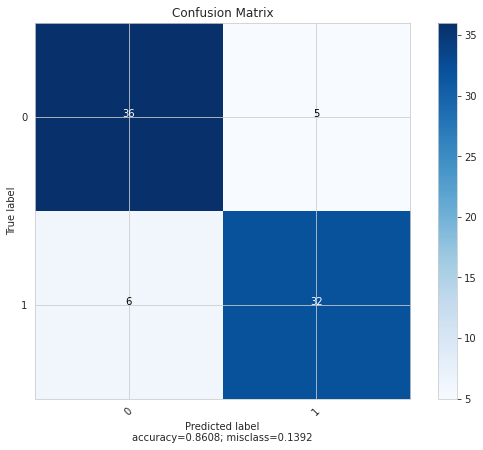

In [195]:
# Permite verificar a acurácia em um formato de tabela
matrix = confusion_matrix(y_valid, previsoes)

# Chamando a função para visualizar a confusion matrix
plot_confusion_matrix(matrix, 
                      target_names = ['0', '1'],
                      normalize    = False,
                      title        = "Confusion Matrix")

# FIM